In [1]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import tensorflow as tf
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score
print("TensorFlow version: ",tf.__version__)  #print the version of tensorflow

TensorFlow version:  2.3.0


In [2]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [3]:
#Helper Functions
def get_weekday2(year, month, day):
    dates = pd.DataFrame()
    dates['y'] = year
    dates['m'] = month
    dates['d'] = day
    dates['dates'] = dates['y'].astype('str') + '-' + dates['m'].astype('str') + '-' + dates['d'].astype('str')
    return get_weekday(dates['dates'])

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/main/Datasets/Combined_PowerWeatherData2.csv')
copy = data
data

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2016,8,10,310.769231,850,11,2.115385,5.775000,122.123077,81.439231,28.846154,31.0,24.0,1010.000000,5289.221903,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
1,2016,8,11,458.363636,846,2,1.945455,5.990364,110.290909,79.874545,29.090909,31.0,25.0,1010.000000,6232.404214,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
2,2016,8,12,419.000000,882,31,2.191667,5.054167,138.166667,76.782500,29.166667,32.0,25.0,1010.000000,6484.952963,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
3,2016,8,13,498.666667,904,47,2.366667,4.021750,141.116667,73.201667,29.666667,33.0,25.0,1010.000000,6098.378307,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
4,2016,8,14,47.666667,97,8,2.588889,5.230667,107.488889,81.852222,28.888889,30.0,26.0,1010.000000,6235.404728,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24241,2019,12,27,601.050000,888,25,2.270000,0.755000,305.250000,67.604500,9.935000,12.0,5.3,998.650000,228.560000,0,"University of California, Berkeley",Anna Head Complex,35000,Classroom
24242,2019,12,28,661.400000,903,14,1.185000,1.285000,170.350000,68.861000,10.400000,12.8,5.3,1001.100000,224.660000,1,"University of California, Berkeley",Anna Head Complex,35000,Classroom
24243,2019,12,29,38.428571,100,1,1.964286,1.971429,202.357143,94.118571,10.707143,11.5,8.4,999.214286,239.420000,1,"University of California, Berkeley",Anna Head Complex,35000,Classroom
24244,2019,12,30,666.350000,883,59,2.105000,1.300000,252.450000,82.484000,10.880000,13.7,6.2,1000.200000,237.920000,0,"University of California, Berkeley",Anna Head Complex,35000,Classroom


In [5]:
data.describe()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,Square Feet
count,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.00000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000,24246.000000
mean,2018.192609,6.748866,15.746144,465.086410,762.074074,56.85012,2.745218,2.726132,182.545192,68.077800,22.010500,24.698952,16.720824,1005.815365,4835.538461,0.285820,99425.628392
std,1.038832,3.410584,8.799943,224.818136,238.411106,85.26018,1.230575,1.504277,85.872012,15.309979,6.394781,6.541984,6.551003,9.081861,3429.201797,0.451814,27215.621821
min,2016.000000,1.000000,1.000000,2.000000,3.000000,1.00000,0.481818,0.286957,10.200000,19.850435,6.218182,7.900000,-3.000000,979.058824,76.649390,0.000000,35000.000000
25%,2017.000000,4.000000,8.000000,292.387500,709.000000,5.00000,1.820000,1.450000,105.466667,59.070952,16.878947,20.200000,10.900000,996.956522,2287.241909,0.000000,81600.000000
50%,2019.000000,7.000000,16.000000,495.083333,857.000000,20.00000,2.636364,2.304100,189.545455,69.960000,23.180000,26.000000,16.800000,1010.000000,3566.244546,0.000000,105775.000000
75%,2019.000000,10.000000,23.000000,661.400000,922.000000,71.00000,3.493333,4.031364,260.571429,79.278000,27.716667,30.000000,23.000000,1012.666667,6995.476610,1.000000,121074.000000
max,2019.000000,12.000000,31.000000,857.900000,1032.000000,581.00000,11.075000,7.117500,351.500000,99.840000,33.076923,37.600000,28.200000,1026.363636,17270.971193,1.000000,141000.000000


In [6]:
#Creating column to denote each building type
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
data['Type'] = encoder.fit_transform(np.reshape(data['Type'].values, (-1,1)))
data['Type'].describe()

count    24246.000000
mean         0.517570
std          0.499702
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Type, dtype: float64

In [7]:
encoder.inverse_transform(np.reshape([0, 1], (-1,1)))

array([['Classroom'],
       ['Laboratory']], dtype=object)

In [8]:
#Removing unnecessary columns
data = data.drop(['University Name', 'Building Name'], axis=1)
data.head()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,Square Feet,Type
0,2016,8,10,310.769231,850,11,2.115385,5.775000,122.123077,81.439231,28.846154,31.0,24.0,1010.0,5289.221903,0,113866,0.0
1,2016,8,11,458.363636,846,2,1.945455,5.990364,110.290909,79.874545,29.090909,31.0,25.0,1010.0,6232.404214,0,113866,0.0
2,2016,8,12,419.000000,882,31,2.191667,5.054167,138.166667,76.782500,29.166667,32.0,25.0,1010.0,6484.952963,0,113866,0.0
3,2016,8,13,498.666667,904,47,2.366667,4.021750,141.116667,73.201667,29.666667,33.0,25.0,1010.0,6098.378307,1,113866,0.0
4,2016,8,14,47.666667,97,8,2.588889,5.230667,107.488889,81.852222,28.888889,30.0,26.0,1010.0,6235.404728,1,113866,0.0


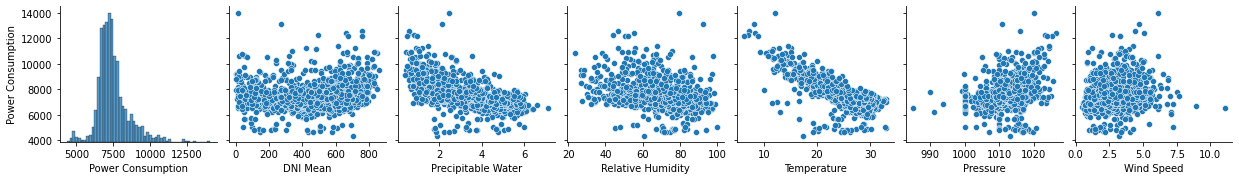

In [9]:
#Select one building's data
view = data[data['Square Feet'] == 113866]
#See graphs for data vs Power Consumption
sns.pairplot(view, x_vars = ['Power Consumption', 'DNI Mean', 'Precipitable Water', 'Relative Humidity', 'Temperature', 'Pressure', 'Wind Speed'], y_vars=['Power Consumption'])
plt.show()

In [10]:
#Splitting into X and Y
X = data.drop(["Power Consumption", "Wind Direction"],axis=1) 
y = data["Power Consumption"]  

In [11]:
y = np.reshape(y.values, (-1,1))

In [12]:
# scaling inputs using StandardScaler
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler() 
y_scaler = StandardScaler()

x_f = x_scaler.fit_transform(X)
y_f = y_scaler.fit_transform(y)  

x_f = pd.DataFrame(x_f)

In [13]:
x_f

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-2.110692,0.366846,-0.652989,-0.686423,0.368807,-0.537778,-0.511831,2.026842,0.872745,1.068965,0.963191,1.111177,0.460778,-0.632620,0.530602,-1.03578
1,-2.110692,0.366846,-0.539349,-0.029904,0.352029,-0.643340,-0.649924,2.170012,0.770542,1.107240,0.963191,1.263829,0.460778,-0.632620,0.530602,-1.03578
2,-2.110692,0.366846,-0.425710,-0.204998,0.503032,-0.303197,-0.449840,1.547643,0.568576,1.119087,1.116053,1.263829,0.460778,-0.632620,0.530602,-1.03578
3,-2.110692,0.366846,-0.312070,0.149369,0.595311,-0.115533,-0.307628,0.861307,0.334682,1.197277,1.268915,1.263829,0.460778,1.580728,0.530602,-1.03578
4,-2.110692,0.366846,-0.198431,-1.856738,-2.789668,-0.572965,-0.127040,1.664977,0.899721,1.075648,0.810329,1.416480,0.460778,1.580728,0.530602,-1.03578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24241,0.777226,1.539690,1.278882,0.604784,0.528199,-0.373572,-0.386183,-1.310379,-0.030915,-1.888376,-1.941187,-1.743406,-0.788992,-0.632620,-2.367279,-1.03578
24242,0.777226,1.539690,1.392521,0.873229,0.591117,-0.502591,-1.267903,-0.958043,0.051157,-1.815659,-1.818897,-1.743406,-0.519218,1.580728,-2.367279,-1.03578
24243,0.777226,1.539690,1.506161,-1.897830,-2.777084,-0.655069,-0.634621,-0.501716,1.700937,-1.767627,-2.017618,-1.270187,-0.726857,1.580728,-2.367279,-1.03578
24244,0.777226,1.539690,1.619800,0.895247,0.507226,0.025216,-0.520270,-0.948071,0.940987,-1.740596,-1.681322,-1.606020,-0.618318,-0.632620,-2.367279,-1.03578


In [14]:
x_f = x_f.values

In [15]:
x_f.dtype

dtype('float64')

In [16]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split  
x_f_train, x_f_test, y_f_train, y_f_test = train_test_split(x_f,y_f, test_size = 0.2, shuffle=True)  

In [17]:
# print the number of training and test damples
print("Number of training samples: ",len(x_f_train))
print("Number of testing samples: ",len(x_f_test))

Number of training samples:  19396
Number of testing samples:  4850


# Building the Model

In [18]:
model = Sequential()

model.add(Dense(512, input_shape=(16, ), activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', name='dense_4'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', name='dense_5'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', name='dense_6'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               8704      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [19]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae'])

#Tensorboard tool callback
log_dir = "logs\\fit3\\" + datetime.now().strftime("%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)

#Reduce Learning rate on Plateau 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose = 1)

#Earlystopping callback
early_stop = EarlyStopping(monitor ='val_loss', min_delta= 1e-3, patience = 50, verbose = 1, restore_best_weights=True)

history = model.fit(x_f_train, y_f_train, callbacks = [tensorboard_callback, early_stop, reduce_lr], 
                    validation_data=(x_f_test, y_f_test), epochs=400, batch_size=90, verbose=1)

Epoch 1/400
216/216 [==============================] - 1s 5ms/step - loss: 0.5619 - mse: 0.5619 - mae: 0.5752 - val_loss: 0.4498 - val_mse: 0.4498 - val_mae: 0.5433
Epoch 2/400
216/216 [==============================] - 1s 4ms/step - loss: 0.4285 - mse: 0.4285 - mae: 0.4941 - val_loss: 0.4147 - val_mse: 0.4147 - val_mae: 0.5239
Epoch 3/400
216/216 [==============================] - 1s 4ms/step - loss: 0.3958 - mse: 0.3958 - mae: 0.4739 - val_loss: 0.4458 - val_mse: 0.4458 - val_mae: 0.5623
Epoch 4/400
216/216 [==============================] - 1s 4ms/step - loss: 0.3647 - mse: 0.3647 - mae: 0.4520 - val_loss: 0.3970 - val_mse: 0.3970 - val_mae: 0.5199
Epoch 5/400
216/216 [==============================] - 1s 4ms/step - loss: 0.3248 - mse: 0.3248 - mae: 0.4194 - val_loss: 0.3394 - val_mse: 0.3394 - val_mae: 0.4634
Epoch 6/400
216/216 [==============================] - 1s 4ms/step - loss: 0.2848 - mse: 0.2848 - mae: 0.3776 - val_loss: 0.3009 - val_mse: 0.3009 - val_mae: 0.4257
Epoch 7/40

# Testing accuracy of Model with validation data

In [36]:
y_f_result = model.predict(x_f_test)
y_result = y_scaler.inverse_transform(y_f_result)
y_actual = y_scaler.inverse_transform(y_f_test)

compare = pd.DataFrame()
compare['Expected'] = y_actual.reshape(1,-1)[0]
compare['Result'] = y_result.reshape(1,-1)[0]
compare['Difference'] = compare['Expected'] - compare['Result']
compare['Percentage Error'] =  abs(100 * compare['Difference']/compare['Expected'])

#Print out percentile descriptions of model accuracy
compare['Percentage Error'].describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.90])

count    4850.000000
mean       32.991764
std        91.142214
min         0.001029
10%         1.623216
25%         4.510004
50%         9.538972
75%        19.078097
90%        59.386870
max      2267.093756
Name: Percentage Error, dtype: float64

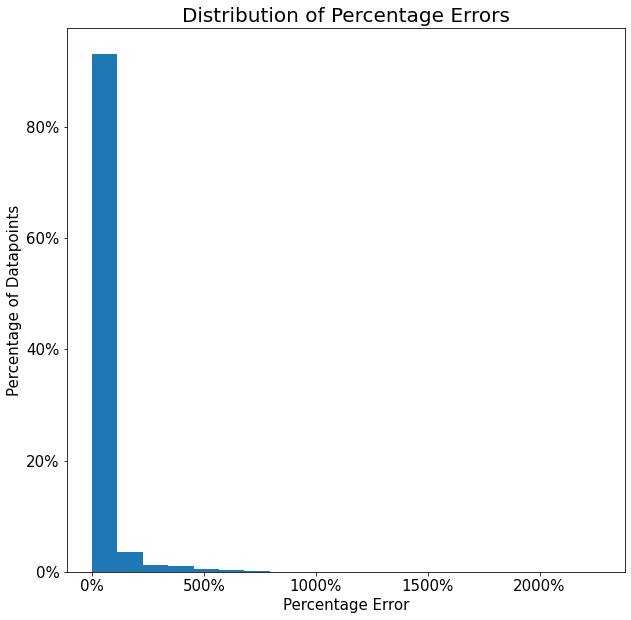

In [78]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize = (10,10))
plt.hist(compare['Percentage Error'], bins = 20, weights=np.ones(len(compare)) / len(compare))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(100))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.ylabel('Percentage of Datapoints', fontsize=15)
plt.xlabel('Percentage Error', fontsize=15)
plt.title('Distribution of Percentage Errors', fontsize=20)
plt.show()

As observed, there are a few outliers in the model, but most of the data lies close to its expected value.

In [22]:
r_score = r2_score(y_actual, y_result)
print("R^2 score: ", r_score)

R^2 score:  0.8932878989929751


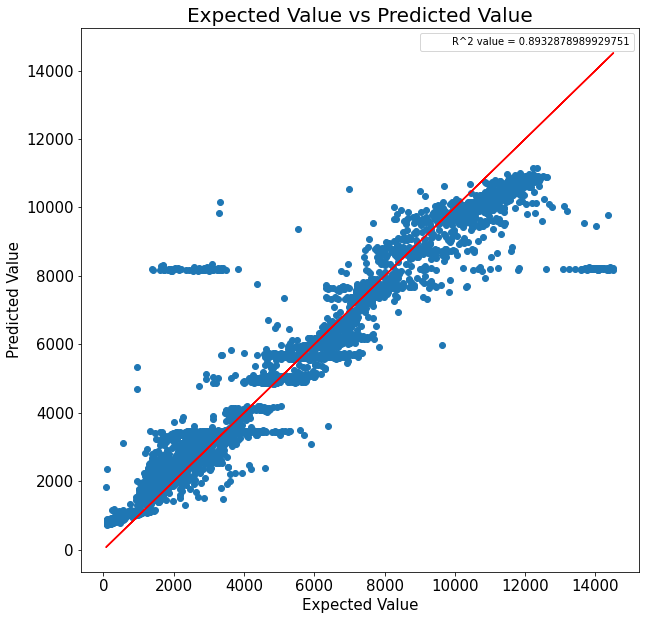

In [75]:
plt.figure(figsize = (10,10))
plt.scatter(compare['Expected'], compare['Result'])
plt.plot(compare['Expected'], compare['Expected'], c='Red')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.ylabel('Predicted Value', fontsize=15)
plt.xlabel('Expected Value', fontsize=15)
plt.title('Expected Value vs Predicted Value', fontsize=20)
plt.plot([], label='R^2 value = ' + str(r_score) , c='White')
plt.legend()
plt.show()

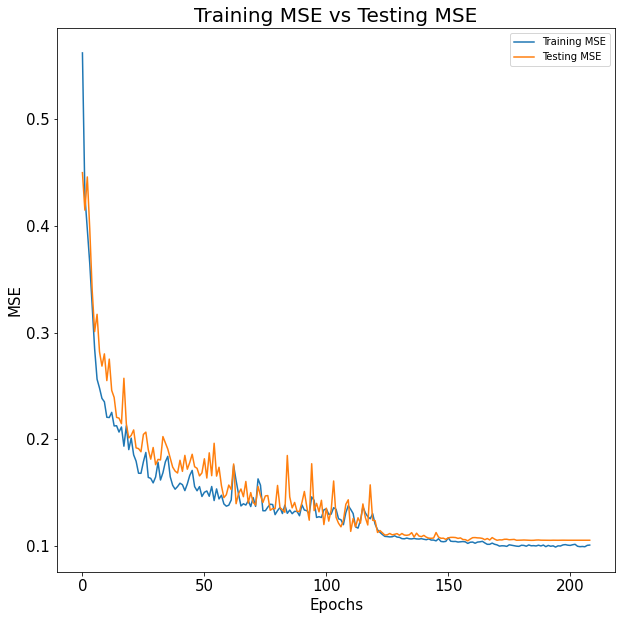

In [77]:
plt.figure(figsize = (10,10))
plt.plot(history.history['mse'],label='Training MSE')
plt.plot(history.history['val_mse'],label='Testing MSE')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Training MSE vs Testing MSE', fontsize=20)
plt.legend()
plt.show()

As observed above, we have a decently high $r^2$ score. An ideal model would achieve 1 as the $r^2$ score.

# Building Model Analysis


In [25]:
def clean_data(location, skiprows = 0):
    df_weather = pd.read_csv(location, skiprows=skiprows)
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [26]:
def training_prep(data, square_feet, building_type):
    data = data.loc[:, ['Year', 'Month', 'Day', 'DNI', 'DNI Max', 'DNI Min', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Temp Max', 'Temp Min', 'Pressure']]
    data.loc[:, 'Weekday'] = get_weekday2(data['Year'], data['Month'], data['Day'])
    data = data.drop(['Wind Direction'], axis=1)
    data.loc[:, 'Square Feet'] = square_feet
    data.loc[:, 'Type'] = building_type
    return data

In [27]:
X

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2016,8,10,310.769231,850,11,2.115385,5.775000,81.439231,28.846154,31.0,24.0,1010.000000,0,113866,0.0
1,2016,8,11,458.363636,846,2,1.945455,5.990364,79.874545,29.090909,31.0,25.0,1010.000000,0,113866,0.0
2,2016,8,12,419.000000,882,31,2.191667,5.054167,76.782500,29.166667,32.0,25.0,1010.000000,0,113866,0.0
3,2016,8,13,498.666667,904,47,2.366667,4.021750,73.201667,29.666667,33.0,25.0,1010.000000,1,113866,0.0
4,2016,8,14,47.666667,97,8,2.588889,5.230667,81.852222,28.888889,30.0,26.0,1010.000000,1,113866,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24241,2019,12,27,601.050000,888,25,2.270000,0.755000,67.604500,9.935000,12.0,5.3,998.650000,0,35000,0.0
24242,2019,12,28,661.400000,903,14,1.185000,1.285000,68.861000,10.400000,12.8,5.3,1001.100000,1,35000,0.0
24243,2019,12,29,38.428571,100,1,1.964286,1.971429,94.118571,10.707143,11.5,8.4,999.214286,1,35000,0.0
24244,2019,12,30,666.350000,883,59,2.105000,1.300000,82.484000,10.880000,13.7,6.2,1000.200000,0,35000,0.0


In [28]:
#Taking data for University of Michigan Research Building
michigan_data = training_prep(clean_data('https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/main/Datasets/AnnArbor_Weather.csv'), 100000, 1)
michigan_data.head()

,Year,Month,Day,DNI,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2019,1,1,52.111111,178,3,0.377778,1.033333,86.873333,4.133333,6.1,0.9,993.888889,0,100000,1
1,2019,1,2,396.000000,751,17,0.180000,0.400000,50.143000,-1.500000,0.9,-5.0,1011.400000,0,100000,1
2,2019,1,3,299.700000,752,7,0.240000,0.740000,83.652000,1.970000,3.6,-0.4,997.400000,0,100000,1
3,2019,1,4,281.900000,576,34,0.190000,1.240000,83.261000,1.970000,4.5,-2.8,997.300000,0,100000,1
4,2019,1,5,10.000000,21,3,0.200000,2.266667,94.240000,2.000000,2.5,1.5,986.000000,1,100000,1


In [29]:
#Applying transform to data
mi_test = x_scaler.transform(michigan_data)

In [30]:
#Testing model:
mi_result = y_scaler.inverse_transform(model.predict(mi_test))
compare = pd.DataFrame()
compare['Month'] = michigan_data['Month']
compare['Result'] = mi_result.reshape(1,-1)[0]
compare.head()

,Month,Result
0,1,8355.600586
1,1,7774.378906
2,1,8283.583984
3,1,8256.445312
4,1,7758.619629


In [31]:
compare = pd.DataFrame(compare.groupby(['Month']).sum().reset_index())
actual = [212259, 240083, 218423, 233777, 240106, 272017, 300123, 295701, 288447, 254802, 228097, 220258]
compare['Actual'] = actual
compare['Difference'] = compare['Actual'] - compare['Result']
compare['Percentage Error'] = 100 * compare['Difference']/compare['Actual']
compare['Percentage Error'] = abs(compare['Percentage Error'])
compare.head(12)

,Month,Result,Actual,Difference,Percentage Error
0,1,241392.265625,212259,-29133.265625,13.725338
1,2,220305.000000,240083,19778.000000,8.237984
2,3,241073.812500,218423,-22650.812500,10.370159
3,4,235661.546875,233777,-1884.546875,0.806130
4,5,243082.468750,240106,-2976.468750,1.239648
5,6,228955.468750,272017,43061.531250,15.830456
6,7,228961.687500,300123,71161.312500,23.710716
7,8,236019.984375,295701,59681.015625,20.182893
8,9,216333.968750,288447,72113.031250,25.000444
9,10,233315.265625,254802,21486.734375,8.432718


In [32]:
compare.describe()

,Month,Result,Actual,Difference,Percentage Error
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,231340.203125,250341.083333,19000.888021,11.012780
std,3.605551,8570.139648,31378.512646,35202.665400,8.729914
min,1.000000,216333.968750,212259.000000,-29133.265625,0.806130
25%,3.750000,226105.914062,226137.250000,-3848.199219,2.621449
50%,6.500000,231138.476562,240094.500000,11807.757812,9.401439
75%,9.250000,237283.441406,276124.500000,47216.402344,16.918565
max,12.000000,243082.468750,300123.000000,72113.031250,25.000444


As observed here, the estimated values seem to be close to the real values. The mean percentage error is about 11%. 

In [33]:
from joblib import dump, load
dump(x_scaler, 'x_scaler.bin', compress=True)
dump(y_scaler, 'y_scaler.bin', compress=True)
model.save('uni_model.h5')